In [32]:
import pandas as pd
import pydicom
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import cv2
import os
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Load the CSV file
df = pd.read_csv('RSNA_breast_cancer_data.csv')

In [2]:
# Function to load DICOM images and resize them
def load_dicom_image(image_path, target_size=(224, 224)):  # Resize to 224x224 for ResNet101
    dicom = pydicom.dcmread(image_path)
    image = dicom.pixel_array
    image_resized = cv2.resize(image, target_size)
    image_normalized = image_resized / np.max(image_resized)  # Normalize pixel values
    
    # Convert grayscale to 3 channels by replicating the grayscale image
    image_rgb = np.stack([image_normalized] * 3, axis=-1)  # Replicate across 3 channels
    return image_rgb

# Load all the images and labels
image_paths = df['image_path'].values
labels = df['cancer'].values

In [3]:
# Prepare data
images = []
for path in image_paths:
    image = load_dicom_image(path)  # Directly use the full path from the CSV
    images.append(image)

images = np.array(images)
labels = np.array(labels)

In [33]:
images.shape

(2374, 224, 224, 3)

In [34]:
# Split data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 50% of the remaining data

# Use ImageDataGenerator for augmentation
train_datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')
val_datagen = ImageDataGenerator()

# Flow the data using ImageDataGenerator
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)

## using PCA

In [ ]:
from sklearn.decomposition import PCA
from tensorflow.keras.models import Model

# Load ResNet101 with pre-trained weights and exclude the top layers
base_model2 = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
base_model2.trainable = False

# Create a model that outputs the features from the base model
feature_extractor = Model(inputs=base_model2.input, outputs=base_model2.output)

# Extract features for the training data
train_features = feature_extractor.predict(X_train)
val_features = feature_extractor.predict(X_val)
test_features = feature_extractor.predict(X_test)

# Flatten the features for PCA (Reshape to 2D)
train_features_flat = train_features.reshape(train_features.shape[0], -1)
val_features_flat = val_features.reshape(val_features.shape[0], -1)
test_features_flat = test_features.reshape(test_features.shape[0], -1)

# Apply PCA for dimensionality reduction (Choose n_components as per your preference)
pca = PCA(n_components=100)  # You can adjust the number of components based on your dataset
train_features_pca = pca.fit_transform(train_features_flat)
val_features_pca = pca.transform(val_features_flat)
test_features_pca = pca.transform(test_features_flat)

60/60 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step


In [ ]:
# Build a deeper and more complex model
model2 = tf.keras.Sequential([
    Dense(1024, activation='relu', input_shape=(train_features_pca.shape[1],)),  # Increased neurons in the first layer
    Dropout(0.5),
    Dense(512, activation='relu'),  # More neurons in the second layer
    Dropout(0.5),
    Dense(256, activation='relu'),  # Third dense layer with fewer neurons
    Dropout(0.5),
    Dense(128, activation='relu'),  # Fourth dense layer
    Dropout(0.5),
    Dense(64, activation='relu'),   # Fifth dense layer
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model2.compile(optimizer=Adam(learning_rate=0.0001),  # Keep learning rate low for complex model
               loss='binary_crossentropy',
               metrics=['accuracy'])

# Display model summary
model2.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_26 (Dense)                │ (None, 1024)           │       103,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 800,769 (3.05 MB)

 Trainable params: 800,769 (3.05 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model with PCA-transformed features
history2 = model2.fit(train_features_pca, y_train,
                    epochs=50,
                    validation_data=(val_features_pca, y_val))

Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6099 - loss: 0.6654 - val_accuracy: 0.6034 - val_loss: 0.6428
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6191 - loss: 0.6359 - val_accuracy: 0.6118 - val_loss: 0.6417
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6034 - loss: 0.6497 - val_accuracy: 0.6034 - val_loss: 0.6382
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6408 - loss: 0.6355 - val_accuracy: 0.6203 - val_loss: 0.6355
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6026 - loss: 0.6552 - val_accuracy: 0.6245 - val_loss: 0.6334
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6024 - loss: 0.6463 - val_accuracy: 0.6287 - val_loss: 0.6309
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6124 - loss: 0.6436 - val_accuracy: 0.6203 - val_loss: 0.6302
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6344 - loss: 0.6323 - val_accuracy: 0.6203 - val_loss:

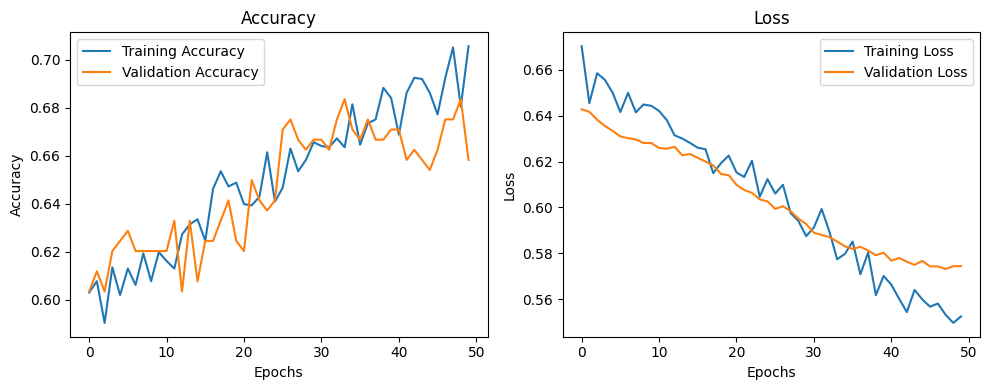

In [ ]:
# Plotting accuracy and loss
plt.figure(figsize=(10, 4))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Evaluate on test data after training is complete
test_loss, test_acc = model2.evaluate(test_features_pca, y_test, verbose=2)
print(f"\nTest accuracy: {test_acc}")

8/8 - 0s - 4ms/step - accuracy: 0.6765 - loss: 0.5797

Test accuracy: 0.6764705777168274


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


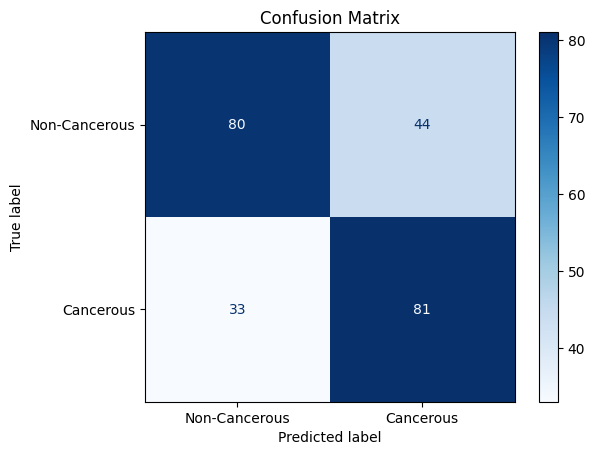

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Get predictions on the test set
y_pred_probs = model2.predict(test_features_pca)  # Get the predicted probabilities
y_pred = (y_pred_probs > 0.5).astype(int)  # Convert probabilities to binary class labels

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Cancerous', 'Cancerous'])
disp.plot(cmap=plt.cm.Blues)

# Show the plot
plt.title('Confusion Matrix')
plt.show()

# Without DIM Reduction

In [6]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Load ResNet101 for feature extraction, without the final classification layer
base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model's layers
base_model.trainable = False

# Create a new model for feature extraction
feature_extractor = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Pool the extracted features
    Flatten()  # Flatten the features to a 1D vector
])

In [7]:
# Extract features from the training set
X_train_features = feature_extractor.predict(X_train)
X_val_features = feature_extractor.predict(X_val)
X_test_features = feature_extractor.predict(X_test)

60/60 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step


In [8]:
# Train a machine learning model (SVM in this case) on the extracted features
classifier = SVC(kernel='linear')  # You can choose other algorithms, like RandomForestClassifier
classifier.fit(X_train_features, y_train)

SVC(kernel='linear')

In [9]:
# Validate the model on the validation set
y_val_pred = classifier.predict(X_val_features)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy: {val_accuracy}')
print(classification_report(y_val, y_val_pred))

# Test the model on the test set
y_test_pred = classifier.predict(X_test_features)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {test_accuracy}')
print(classification_report(y_test, y_test_pred))

Validation Accuracy: 0.6286919831223629
              precision    recall  f1-score   support

           0       0.65      0.63      0.64       123
           1       0.61      0.63      0.62       114

    accuracy                           0.63       237
   macro avg       0.63      0.63      0.63       237
weighted avg       0.63      0.63      0.63       237

Test Accuracy: 0.6596638655462185
              precision    recall  f1-score   support

           0       0.71      0.59      0.64       124
           1       0.62      0.74      0.67       114

    accuracy                           0.66       238
   macro avg       0.67      0.66      0.66       238
weighted avg       0.67      0.66      0.66       238



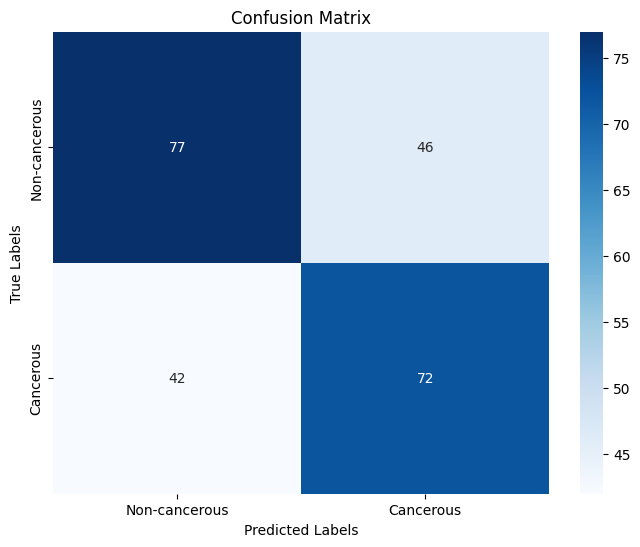

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Predict on the validation set
y_val_pred = classifier.predict(X_val_features)

# Create confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-cancerous', 'Cancerous'], yticklabels=['Non-cancerous', 'Cancerous'])
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

## SVM GridsearchCV

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Define the parameter grid to search over
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'kernel': ['linear', 'rbf'],  # Linear or Radial Basis Function kernel
    'gamma': ['scale', 'auto']  # Kernel coefficient for 'rbf'
}

# Initialize the SVM model
svm = SVC()

# Set up GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=svm, 
                           param_grid=param_grid, 
                           cv=5, 
                           scoring='accuracy', 
                           verbose=2)

# Fit GridSearchCV to the training features and labels
grid_search.fit(X_train_features, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f'Best parameters: {best_params}')
print(f'Best cross-validation accuracy: {best_score}')

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   2.0s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   1.9s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   1.8s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   2.0s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   1.9s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   2.4s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   2.8s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   2.9s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   2.8s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   2.4s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   2.3s
[CV] END ...................C=0.1, gamma=auto, k

In [27]:
# Use the best model found by GridSearchCV to predict on the validation set
best_svm = grid_search.best_estimator_
y_val_pred = best_svm.predict(X_val_features)

# Evaluate the model on the validation set
from sklearn.metrics import classification_report, accuracy_score

val_accuracy = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy: {val_accuracy}')
print(classification_report(y_val, y_val_pred))

Validation Accuracy: 0.6286919831223629
              precision    recall  f1-score   support

           0       0.65      0.63      0.64       123
           1       0.61      0.63      0.62       114

    accuracy                           0.63       237
   macro avg       0.63      0.63      0.63       237
weighted avg       0.63      0.63      0.63       237



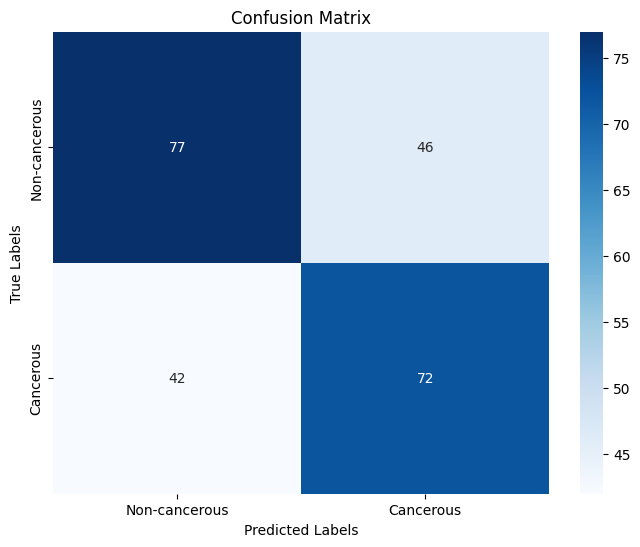

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Create confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-cancerous', 'Cancerous'], yticklabels=['Non-cancerous', 'Cancerous'])
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

## LDA + SVM

In [29]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Load ResNet101 for feature extraction, without the final classification layer
base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model's layers
base_model.trainable = False

# Create a new model for feature extraction
feature_extractor = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Pool the extracted features
    Flatten()  # Flatten the features to a 1D vector
])

# Extract features from the training set
X_train_features = feature_extractor.predict(X_train)
X_val_features = feature_extractor.predict(X_val)
X_test_features = feature_extractor.predict(X_test)

60/60 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step


In [30]:
# Apply LDA for dimensionality reduction
lda = LDA(n_components=1)  # Choose the number of components, adjust as needed
X_train_lda = lda.fit_transform(X_train_features, y_train)
X_val_lda = lda.transform(X_val_features)
X_test_lda = lda.transform(X_test_features)

# Train a machine learning model (SVM in this case) on the reduced features
classifier = SVC(C=1, gamma ='scale', kernel ='linear')
classifier.fit(X_train_lda, y_train)

SVC(C=1, kernel='linear')

In [31]:
# Validate the model on the validation set
y_val_pred = classifier.predict(X_val_lda)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy: {val_accuracy}')
print(classification_report(y_val, y_val_pred))

# Test the model on the test set
y_test_pred = classifier.predict(X_test_lda)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {test_accuracy}')
print(classification_report(y_test, y_test_pred))

Validation Accuracy: 0.5949367088607594
              precision    recall  f1-score   support

           0       0.63      0.54      0.58       123
           1       0.57      0.65      0.61       114

    accuracy                           0.59       237
   macro avg       0.60      0.60      0.59       237
weighted avg       0.60      0.59      0.59       237

Test Accuracy: 0.6176470588235294
              precision    recall  f1-score   support

           0       0.65      0.57      0.61       124
           1       0.59      0.67      0.63       114

    accuracy                           0.62       238
   macro avg       0.62      0.62      0.62       238
weighted avg       0.62      0.62      0.62       238



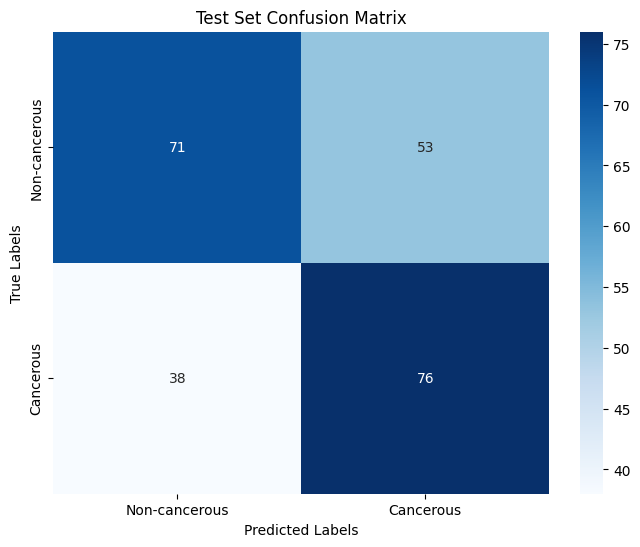

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Create confusion matrix for test set
cm_test = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix for test set
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-cancerous', 'Cancerous'], yticklabels=['Non-cancerous', 'Cancerous'])
plt.title('Test Set Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

## PCA + SVM

In [16]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Load ResNet101 for feature extraction, without the final classification layer
base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model's layers
base_model.trainable = False

# Create a new model for feature extraction
feature_extractor = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Pool the extracted features
    Flatten()  # Flatten the features to a 1D vector
])

In [17]:
# Extract features from the training set
X_train_features = feature_extractor.predict(X_train)
X_val_features = feature_extractor.predict(X_val)
X_test_features = feature_extractor.predict(X_test)

60/60 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step


In [18]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=100)  # You can adjust the number of components based on variance retained
X_train_pca = pca.fit_transform(X_train_features)
X_val_pca = pca.transform(X_val_features)
X_test_pca = pca.transform(X_test_features)

In [19]:
# Train a machine learning model on the reduced features
classifier = SVC(kernel='linear')  # You can choose other algorithms, like RandomForestClassifier
classifier.fit(X_train_pca, y_train)

SVC(kernel='linear')

In [20]:
# Validate the model on the validation set
y_val_pred = classifier.predict(X_val_pca)
print(classification_report(y_val, y_val_pred))

# Test the model on the test set
y_test_pred = classifier.predict(X_test_pca)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.66      0.62      0.64       123
           1       0.61      0.66      0.64       114

    accuracy                           0.64       237
   macro avg       0.64      0.64      0.64       237
weighted avg       0.64      0.64      0.64       237

              precision    recall  f1-score   support

           0       0.70      0.59      0.64       124
           1       0.62      0.72      0.66       114

    accuracy                           0.65       238
   macro avg       0.66      0.65      0.65       238
weighted avg       0.66      0.65      0.65       238



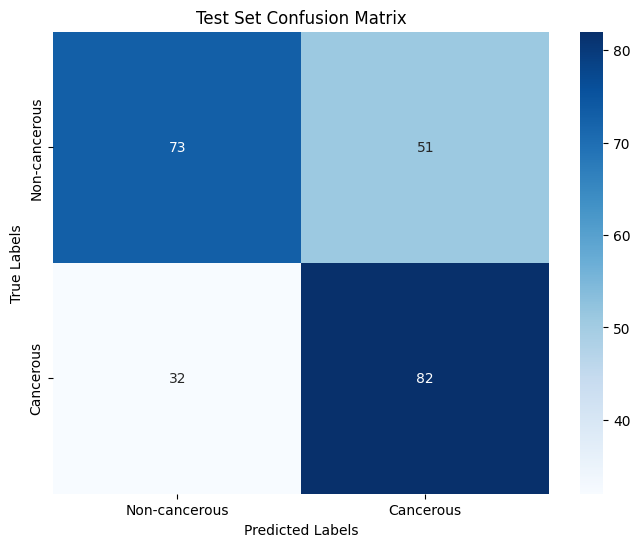

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Predict on the test set
y_test_pred = classifier.predict(X_test_pca)

# Create confusion matrix for test set
cm_test = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix for test set
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-cancerous', 'Cancerous'], yticklabels=['Non-cancerous', 'Cancerous'])
plt.title('Test Set Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()


## first extracting, then splitting - SVM

In [33]:
# Load ResNet101 for feature extraction, without the final classification layer
base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model's layers
base_model.trainable = False

# Create a new model for feature extraction
feature_extractor = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Pool the extracted features
    Flatten()  # Flatten the features to a 1D vector
])

# Extract features from the entire dataset
features = feature_extractor.predict(images)

75/75 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step


In [42]:
# Now split the extracted features into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Initialize SVM model
classifier = SVC(C=1, gamma ='scale', kernel ='linear')

# Train the SVM model
classifier.fit(X_train, y_train)

SVC(C=1, kernel='linear')

In [43]:
# Predict on the test set
y_test_pred = classifier.predict(X_test)

# Evaluate the model on the test set
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.67      0.61      0.64       247
           1       0.62      0.68      0.65       228

    accuracy                           0.64       475
   macro avg       0.64      0.64      0.64       475
weighted avg       0.65      0.64      0.64       475



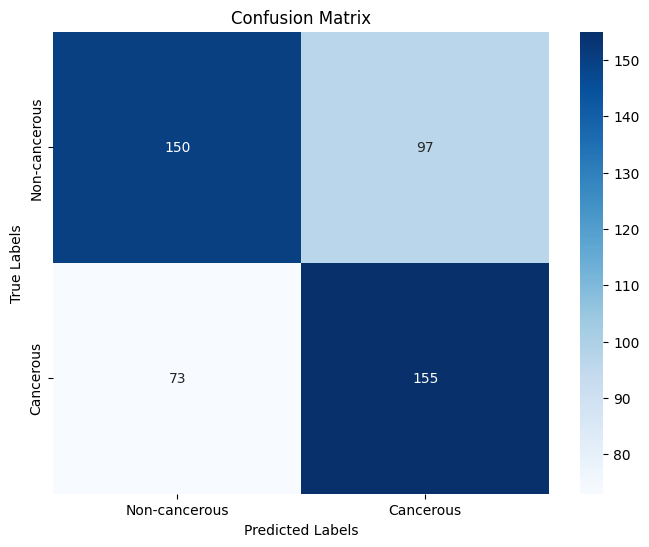

In [36]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-cancerous', 'Cancerous'], yticklabels=['Non-cancerous', 'Cancerous'])
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

## first extracting, then splitting - RF

In [ ]:
# Load ResNet101 for feature extraction, without the final classification layer
base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model's layers
base_model.trainable = False

# Create a new model for feature extraction
feature_extractor = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Pool the extracted features
    Flatten()  # Flatten the features to a 1D vector
])

# Extract features from the entire dataset
features = feature_extractor.predict(images)

In [39]:
from sklearn.ensemble import RandomForestClassifier

# Now split the extracted features into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Initialize Random Forest model
classifier = RandomForestClassifier(n_estimators=100, random_state=42)  # You can tune the hyperparameters

# Train the Random Forest model
classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [40]:
# Predict on the test set
y_test_pred = classifier.predict(X_test)

# Evaluate the model on the test set
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.67      0.77      0.72       247
           1       0.70      0.58      0.63       228

    accuracy                           0.68       475
   macro avg       0.68      0.68      0.67       475
weighted avg       0.68      0.68      0.68       475



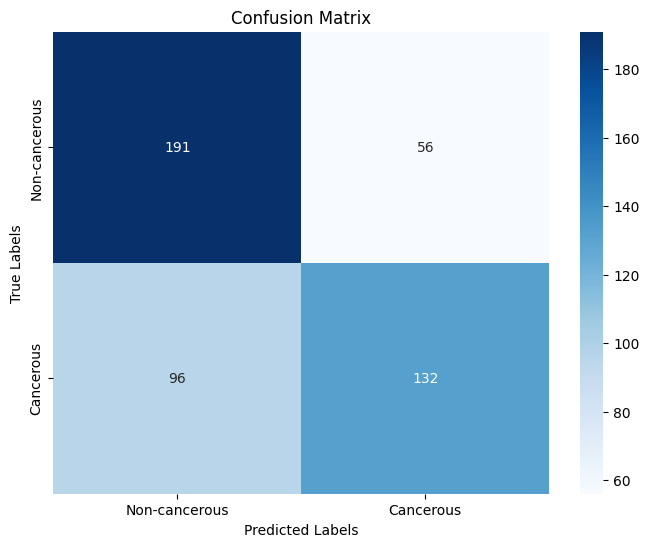

In [41]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-cancerous', 'Cancerous'], yticklabels=['Non-cancerous', 'Cancerous'])
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

## RF - GridsearchCV

In [61]:
from tensorflow.keras.applications import InceptionV3

# Load InceptionV3 for feature extraction, without the final classification layer
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model's layers
base_model.trainable = False

# Create a new model for feature extraction
feature_extractor = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Flatten()
])

# Extract features from the entire dataset
features = feature_extractor.predict(images)

75/75 ━━━━━━━━━━━━━━━━━━━━ 47s 611ms/step


In [62]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Now split the extracted features into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Initialize Random Forest model
classifier = RandomForestClassifier(random_state=42)

# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],    # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False]        # Whether bootstrap samples are used when building trees
}

# Set up GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

# Fit GridSearchCV to the training features and labels
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy', verbose=2)

In [64]:
# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f'Best parameters: {best_params}')

Best parameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


In [65]:
# Use the best model found by GridSearchCV to predict on the test set
best_rf = grid_search.best_estimator_
y_test_pred = best_rf.predict(X_test)

# Evaluate the model on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {test_accuracy}')
print(classification_report(y_test, y_test_pred))

Test Accuracy: 0.6336842105263157
              precision    recall  f1-score   support

           0       0.63      0.70      0.66       247
           1       0.63      0.57      0.60       228

    accuracy                           0.63       475
   macro avg       0.63      0.63      0.63       475
weighted avg       0.63      0.63      0.63       475



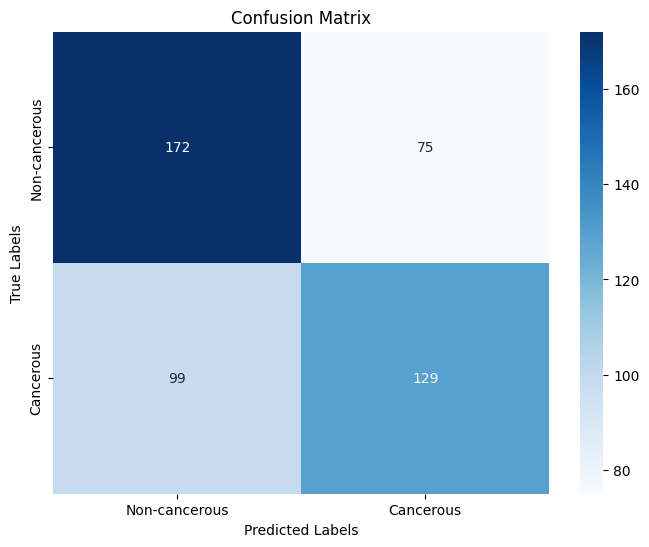

In [66]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-cancerous', 'Cancerous'], yticklabels=['Non-cancerous', 'Cancerous'])
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()